# Gradient boosting model on Spark

In this notebook, we use a state-of-the-art technique for classification and regression (a gradient boosted model applied on an ensemble of weak learners, in this case decision trees) to classify our pre-processed dataset. Specifically, we test the performance of our model with five different sets of features; then, we run a cross-validation on the one yielding the best results, to further optimize the obtained results.

In [1]:
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import VectorAssembler, OneHotEncoder
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## Input data parsing

In [2]:
inputPath = "/user/s291516/preprocessed/"
trainData = spark.read.format("csv").option("header", True).option("inferSchema", True).load(inputPath + "trainData/").cache()
testData = spark.read.format("csv").option("header", True).option("inferSchema", True).load(inputPath + "testData/").cache()

## Evaluators definition

In [3]:
rmseEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="NumBikes+1", metricName="rmse")
r2Evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="NumBikes+1", metricName="r2")
resultsDF = pd.DataFrame(columns=["Features", "Metric", "Value"])

## Label mapper definition

For prediction purposes, we are going to use the "diff" version of the features as produced in the data preprocessing notebook. The `LabelMapper` transformer will be used to translate back the "diff" prediction to a full prediction, obtained by summing the obtained prediction to the value of the `NumBikes` attribute.

In [4]:
class LabelMapper(Transformer):
    def _transform(self, inputDF):
        return inputDF.withColumn("prediction", F.col("prediction") + F.col("NumBikes"))

## Solution #1: only numerical features

In our first solution, we use only the numerical features exposed by our dataset (`NumBikesDiff-3`, `NumBikesDiff-2`, `NumBikesDiff-1`, `NumBikesDiff` and `NumBikes`) to predict the value of `NumBikesDiff+1`.

In [5]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=["NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes"], outputCol="features"),
    GBTRegressor(labelCol="NumBikesDiff+1", seed=42),
    LabelMapper()
])

model = pipeline.fit(trainData)

Analyzing the distribution of feature importance estimation with respect to the base learner and random forest cases, we observe that the gradient boosted model spreads even more the contribution to the information gain onto the different features, which become all relevant to the estimation of the target value.

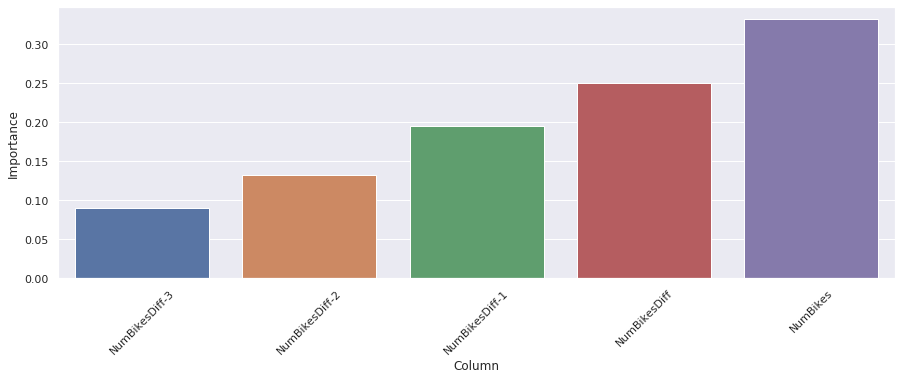

In [6]:
importanceDF = pd.DataFrame({
    "Column": model.stages[0].getInputCols(),
    "Importance": model.stages[1].featureImportances
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=importanceDF, x="Column", y="Importance", ax=ax)
ax.set_xticklabels(labels=importanceDF["Column"], rotation=45);

In this case, results in terms of test evaluation metrics are marginally better than both the single decision tree and the random forest models.

In [7]:
predictedTestData = model.transform(testData)

rmse = rmseEvaluator.evaluate(predictedTestData)
print("RMSE:", rmse)

r2 = r2Evaluator.evaluate(predictedTestData)
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Features": "Only numerical", "Metric": "RMSE", "Value": rmse},
    {"Features": "Only numerical", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4310662623158663
R2: 0.966897705416078


## Solution #2: simple categorical features

In the second solution, we enlarge the feature space by adding the values categorical features (the hour, the day of the week, and the zone of the station) into the model. Note that in this case we do not need to previously encode our features (for example, using one-hot encoding): decision trees indeed do not regress directly on any features; rather, they use them to design proper split values, and in this sense it does not matter if the feature is numerical or categorical.

In [8]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=[
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "Hour", "DayOfWeek", "Zone"
    ], outputCol="features"),
    GBTRegressor(labelCol="NumBikesDiff+1", seed=42),
    LabelMapper()
])

model = pipeline.fit(trainData)

In terms of feature importance, also in this case we observe a pretty uniform distribution of the information gain contribution to all the attributes, with some categorical attributes such as `Zone` and `Hour` even being considered more relevant than the numerical attribute `NumBikes`.

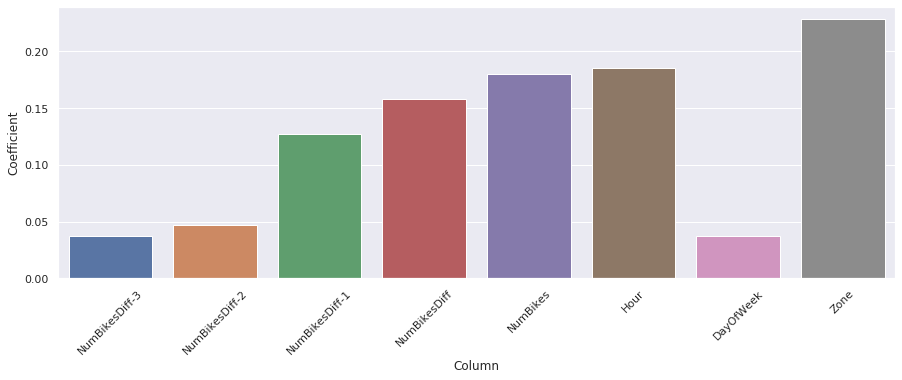

In [9]:
coefficientsDF = pd.DataFrame({
    "Column": model.stages[0].getInputCols(),
    "Coefficient": model.stages[1].featureImportances
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=coefficientsDF, x="Column", y="Coefficient", ax=ax)
ax.set_xticklabels(labels=coefficientsDF["Column"], rotation=45);

This features combination already improves quite significantly over the previous solution and the models fitted on the same set of features by other algorithms, as shown by the following evaluation metrics.

In [10]:
predictedTestData = model.transform(testData)

rmse = rmseEvaluator.evaluate(predictedTestData)
print("RMSE:", rmse)

r2 = r2Evaluator.evaluate(predictedTestData)
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Features": "Categorical OH", "Metric": "RMSE", "Value": rmse},
    {"Features": "Categorical OH", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4264223750198661
R2: 0.967112194303256


## Solution #3: disjoint, effect-encoded categorical features

In the third solution, we use the effect-encoded version of our categorical features, considering only the "disjoint" ones (i.e., we consider separately the effect of the hour, day of the week, and zone of the station).

In [11]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=[
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "AvgByHour", "AvgByWeekday", "AvgByZone"
    ], outputCol="features"),
    GBTRegressor(labelCol="NumBikesDiff+1", seed=42),
    LabelMapper()
])

model = pipeline.fit(trainData)

Similar considerations on features importances may be done also in this case, with the gradient boosting model apparently favoring the "spread" of relevance on more features, among which `AvgByZone` is considered the biggest contribution to the information gain.

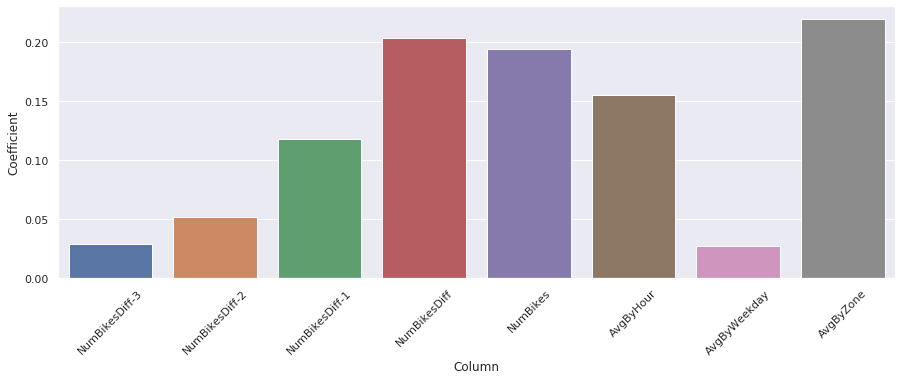

In [12]:
coefficientsDF = pd.DataFrame({
    "Column": model.stages[0].getInputCols(),
    "Coefficient": model.stages[1].featureImportances
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=coefficientsDF, x="Column", y="Coefficient", ax=ax)
ax.set_xticklabels(labels=coefficientsDF["Column"], rotation=45);

The resulting model performs slightly better than the previous solution.

In [13]:
predictedTestData = model.transform(testData)

rmse = rmseEvaluator.evaluate(predictedTestData)
print("RMSE:", rmse)

r2 = r2Evaluator.evaluate(predictedTestData)
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Features": "Disjoint effect", "Metric": "RMSE", "Value": rmse},
    {"Features": "Disjoint effect", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4253007522691896
R2: 0.9671638945695789


## Solution #4: combined, effect-encoded categorical features

Here, we consider a solution in which we use all the available numerical features, plus the joint average computed considering all the categorical values at once.

In [14]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=["NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes", "AvgCombined"], outputCol="features"),
    GBTRegressor(labelCol="NumBikesDiff+1", seed=42),
    LabelMapper()
])

model = pipeline.fit(trainData)

In the gradient boosted case, we observe that the three variables `NumBikesDiff`, `NumBikes` and `AvgCombined` contribute almost equally to the information gain, followed by the other predictors which share about 25% of the total importance.

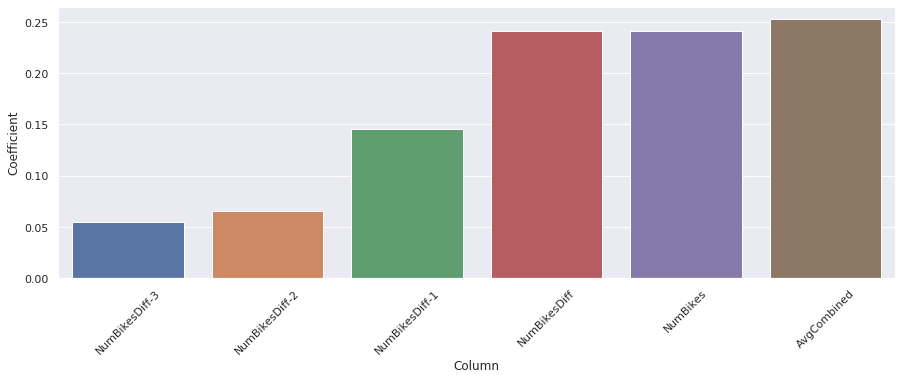

In [15]:
coefficientsDF = pd.DataFrame({
    "Column": model.stages[0].getInputCols(),
    "Coefficient": model.stages[1].featureImportances
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=coefficientsDF, x="Column", y="Coefficient", ax=ax)
ax.set_xticklabels(labels=coefficientsDF["Column"], rotation=45);

This solution improves even more on the results of solution #2 and #3, outperforming the corresponding decision tree and random forest by a good margin (1.0 and 0.8 RMSE points, respectively).

In [16]:
predictedTestData = model.transform(testData)

rmse = rmseEvaluator.evaluate(predictedTestData)
print("RMSE:", rmse)

r2 = r2Evaluator.evaluate(predictedTestData)
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Features": "Combined effect", "Metric": "RMSE", "Value": rmse},
    {"Features": "Combined effect", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.420805939664375
R2: 0.9673706711644559


## Solution #5: putting all together

Finally, we test a solution in which all the aforementioned features are fed to the learning algorithm.

In [17]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=[
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "Hour", "DayOfWeek", "Zone",
        "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
    ], outputCol="features"),
    GBTRegressor(labelCol="NumBikesDiff+1", seed=42),
    LabelMapper()
])

model = pipeline.fit(trainData)

As it has been observed multiple times in these experiments, adding features over the ones used in the previous solution contributes to the spreading of the obtained information gain on multiple attributes. The most relevant predictors remain `NumBikesDiff`, `NumBikes` and `AvgCombined`, but these "only" account for a total of 60% of the information gain; the remaining 40% is split across the other features.

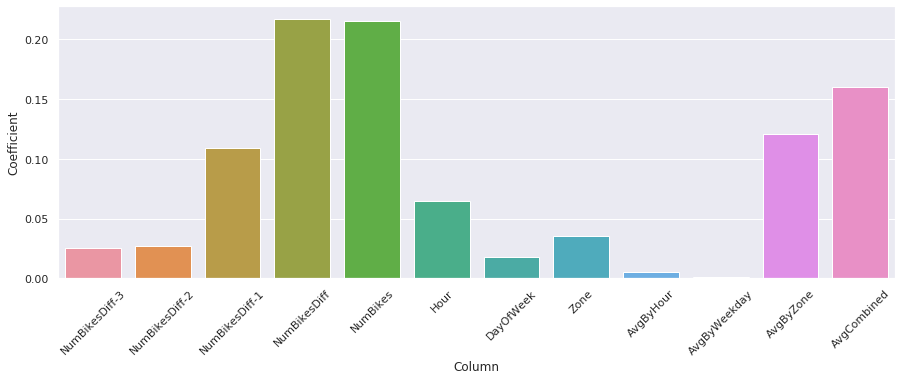

In [18]:
coefficientsDF = pd.DataFrame({
    "Column": model.stages[0].getInputCols(),
    "Coefficient": model.stages[1].featureImportances
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=coefficientsDF, x="Column", y="Coefficient", ax=ax)
ax.set_xticklabels(labels=coefficientsDF["Column"], rotation=45);

This model again slightly improves on the previous solution, performing on par with the optimized random forest model.

In [19]:
predictedTestData = model.transform(testData)

rmse = rmseEvaluator.evaluate(predictedTestData)
print("RMSE:", rmse)

r2 = r2Evaluator.evaluate(predictedTestData)
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Features": "All", "Metric": "RMSE", "Value": rmse},
    {"Features": "All", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4177054744146025
R2: 0.9675129224257252


## Hyperparameter optimization

For solution #5, we run an optimization procedure to determine the best value for the parameters of the regression model, so to increase even further the performance of our model. To do so, we used the parameter grid defined in the cell below, in which we tested different values of all the parameters of Spark's gradient boosted tree model; then, we fitted a `Pipeline` object using a `CrossValidator` stage (the number of CV folds was set to its default value of 3).

**Warning**: running this cross-validation procedure requires ~12 hours. Do it only if necessary.

In [20]:
gbt = GBTRegressor()
grid = ParamGridBuilder() \
    .baseOn({gbt.labelCol: "NumBikesDiff+1", gbt.seed: 42}) \
    .addGrid(gbt.maxDepth, [5, 10]) \
    .addGrid(gbt.minInstancesPerNode, [1, 10]) \
    .addGrid(gbt.minInfoGain, [0, 0.1]) \
    .addGrid(gbt.subsamplingRate, [1, 0.75]) \
    .addGrid(gbt.maxIter, [20, 50]) \
    .addGrid(gbt.stepSize, [0.1, 0.25]) \
    .addGrid(gbt.featureSubsetStrategy, ["all", "onethird"]) \
    .build()

In [21]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=[
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "Hour", "DayOfWeek", "Zone",
        "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
    ], outputCol="features"),
    CrossValidator(estimator=gbt, estimatorParamMaps=grid, evaluator=RegressionEvaluator(predictionCol="prediction", labelCol="NumBikesDiff+1", metricName="rmse")),
    LabelMapper()
])

model = pipeline.fit(trainData)

The overall best model is characterized by the parameters below.

In [22]:
print("Best model params:")
print("\n".join([f"- {x[0].name}: {x[1]}" for x in model.stages[1].bestModel.extractParamMap().items()]))

Best model params:
- cacheNodeIds: False
- checkpointInterval: 10
- featureSubsetStrategy: all
- featuresCol: features
- impurity: variance
- labelCol: NumBikesDiff+1
- lossType: squared
- maxBins: 32
- maxDepth: 5
- maxIter: 50
- maxMemoryInMB: 256
- minInfoGain: 0.0
- minInstancesPerNode: 1
- predictionCol: prediction
- seed: 42
- stepSize: 0.25
- subsamplingRate: 1.0


In the optimized model we observe even more the spreading of feature importance over all of the predictors; no attribute has zero (or nearly zero) contribution to the overall information gain, and the most informative attribute (`NumBikes`) contributes only for about 17.5% of the total importance.

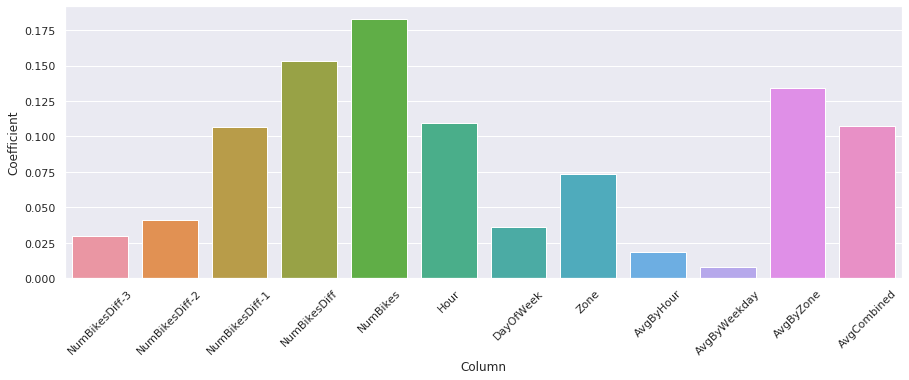

In [23]:
coefficientsDF = pd.DataFrame({
    "Column": model.stages[0].getInputCols(),
    "Coefficient": model.stages[1].bestModel.featureImportances
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=coefficientsDF, x="Column", y="Coefficient", ax=ax)
ax.set_xticklabels(labels=coefficientsDF["Column"], rotation=45);

Applying the optimized model on our test data, we observe a significant improvement of the evaluation metrics, which outperforms both the single decision tree and the random forest solutions by a few decimal points.

In [24]:
predictedTestData = model.transform(testData)

rmse = rmseEvaluator.evaluate(predictedTestData)
print("RMSE:", rmse)

r2 = r2Evaluator.evaluate(predictedTestData)
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Features": "All (CV)", "Metric": "RMSE", "Value": rmse},
    {"Features": "All (CV)", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4109694324580342
R2: 0.9678209052052535


## Comparison of the results

The two graphs below summarize the evolution of the RMSE and R2 metrics for the different sets of features tested.

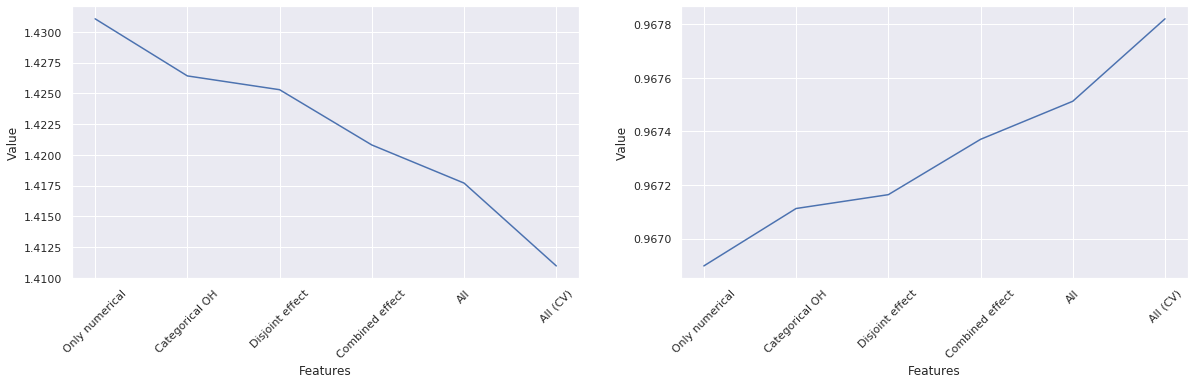

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.lineplot(data=resultsDF[resultsDF["Metric"] == "RMSE"], x="Features", y="Value", ax=ax[0])
sns.lineplot(data=resultsDF[resultsDF["Metric"] == "R2"], x="Features", y="Value", ax=ax[1])
ax[0].set_xticklabels(labels=resultsDF[resultsDF["Metric"] == "RMSE"]["Features"], rotation=45)
ax[1].set_xticklabels(labels=resultsDF[resultsDF["Metric"] == "R2"]["Features"], rotation=45);